In [80]:
import numpy as np
import math
import random
import torch
import carla
import time
import matplotlib.pyplot as plt

In [81]:
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.load_world('Town03')

In [108]:
blueprint_library = world.get_blueprint_library()
vehicle_bp = blueprint_library.filter("vehicle.audi.tt")[0]
starting_point = world.get_map().get_spawn_points()[0]
vehicle = world.try_spawn_actor(vehicle_bp,starting_point )
vehicle_pos = vehicle.get_transform()
lidar_bp = blueprint_library.find('sensor.lidar.ray_cast')
lidar_blueprint = blueprint_library.find("sensor.lidar.ray_cast")
lidar_blueprint.set_attribute("channels", str(32))
lidar_blueprint.set_attribute("points_per_second", str(100000))
lidar_blueprint.set_attribute("rotation_frequency", str(10.0))
lidar_blueprint.set_attribute("upper_fov", str(30.0))
lidar_blueprint.set_attribute("lower_fov", str(-25.0))
lidar_blueprint.set_attribute("range", str(100.0))
spectator_rotation = vehicle_pos.rotation
lidar_transform = carla.Transform(starting_point.location, spectator_rotation)
lidar_sensor = world.spawn_actor(lidar_blueprint, lidar_transform, attach_to = vehicle)

In [109]:
# def lidar_callback(data):
#         points = np.frombuffer(data.raw_data, dtype=np.float32).reshape(-1, 4)
#         print(f"Number of LIDAR points: {len(points)}")

In [110]:
bounding_box = vehicle.bounding_box
vehicle_length = bounding_box.extent.x
print("Car Length:")
print(vehicle_length)

Car Length:
2.0906050205230713


In [111]:
def get_steering_angle(vehicle_location, target_location):
    dx = target_location[0] - vehicle_location.location.x
    dy = target_location[1] - vehicle_location.location.y
    angle_to_target = math.atan2(dy, dx)
    current_yaw = math.radians(vehicle_location.rotation.yaw)  
    steering_angle = angle_to_target - current_yaw
    steering_angle = (steering_angle + math.pi) % (2 * math.pi) - math.pi

    return steering_angle
    

In [112]:
def calculate_throttle(vehicle_location, target_location):
    max_throttle = 0.4
    dx = target_location[0] - vehicle_location.location.x
    dy = target_location[1] - vehicle_location.location.y
    distance_to_target = math.sqrt(dx**2 + dy**2)

    if distance_to_target > 20.0:
        throttle = max_throttle  
    elif distance_to_target > 10.0:
        throttle = max_throttle * 0.5  
    else:
        throttle = max_throttle * 0.3  

    return throttle

In [113]:
# Node class representing a state in the space
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0

# RRT* algorithm
class RRTStar:
    def __init__(self, vehicle_length, start, goal,map_size, carla_world, vehicle,step_size=1.0, max_iter=900):
        self.start = Node(start[0],start[1])
        self.goal = Node(goal[0], goal[1])
        self.map_size = map_size
        self.step_size = step_size
        self.max_iter = max_iter
        self.node_list = [self.start]
        self.goal_region_radius = 1.5
        self.search_radius = 2.0
        self.path = None
        self.goal_reached = False
        self.carla_world = carla_world
        self.vehicle = vehicle
        self.lidar_data = []
        self.vehicle_length = vehicle_length
        
    def get_lidar_data(self, lidar_sensor):
        """Start LIDAR sensor and listen for data updates."""
        lidar_sensor.listen(lambda data: self.process_lidar_data(data))

    def process_lidar_data(self, data):
        # self.lidar_data = self.get_lidar_data()
        lidar = []
        for detection in data:
            ox = detection.point.x
            oy = detection.point.y
            size = detection.point.z
            lidar.append((ox, oy, size))
        self.lidar_data = lidar  
        print("Lidar Data Updated:", lidar)

    def get_nearest_node(self, node_list, rand_node):
        distances = [np.linalg.norm([node.x - rand_node.x, node.y - rand_node.y]) for node in node_list]
        nearest_node_idx = np.argmin(distances)
        return node_list[nearest_node_idx]
    
    def is_collision_free(self, node):
        for (ox, oy, size) in self.lidar_data:
            distance = math.sqrt((ox - node.x) ** 2 + (oy - node.y) ** 2)
            if distance <= size + self.vehicle_length / 2:  # Use vehicle dimensions for clearance
                return False
        return True
    
    def plan(self):
        """Main RRT* planning loop."""
        for i in range(self.max_iter):
            rand_node = self.get_random_node()
            nearest_node = self.get_nearest_node(self.node_list, rand_node)
            new_node = self.steer(nearest_node, rand_node)

            if self.is_collision_free(new_node):
                neighbors = self.find_neighbors(new_node)
                new_node = self.choose_parent(neighbors, nearest_node, new_node)
                self.node_list.append(new_node)
                self.rewire(new_node, neighbors)

            if (self.reached_goal(new_node)):
                    self.path = self.generate_final_path(new_node)
                    self.goal_reached = True
                    self.move_vehicle_along_path()
                    return
        if not self.goal_reached:
                    print("Goal not reached after maximum iterations. Adjusting parameters...")
                    self.step_size *= 0.8 
                    self.max_iter += 100  
                    print(f"New step size: {self.step_size}, New max iterations: {self.max_iter}")

    def get_random_node(self):
        if random.random() > 0.2:
            return Node(random.uniform(0, self.map_size[0]), random.uniform(0, self.map_size[1]))
        else:
            return Node(self.goal.x, self.goal.y)
        
    def steer(self, from_node, to_node):
        """Steer from one node to another, step-by-step."""
        theta = math.atan2(to_node.y - from_node.y, to_node.x - from_node.x)
        new_node = Node(from_node.x + self.step_size * math.cos(theta),
                        from_node.y + self.step_size * math.sin(theta))
        new_node.cost = from_node.cost + self.step_size
        new_node.parent = from_node
        return new_node

    
    
    def find_neighbors(self, new_node):
        """Find nearby nodes within the search radius."""
        return [node for node in self.node_list
                if np.linalg.norm([node.x - new_node.x, node.y - new_node.y]) < self.search_radius]

    def choose_parent(self, neighbors, nearest_node, new_node):
        """Choose the best parent for the new node based on cost."""
        min_cost = nearest_node.cost + np.linalg.norm([new_node.x - nearest_node.x, new_node.y - nearest_node.y])
        best_node = nearest_node

        for neighbor in neighbors:
            cost = neighbor.cost + np.linalg.norm([new_node.x - neighbor.x, new_node.y - neighbor.y])
            if cost < min_cost and self.is_collision_free(neighbor):
                best_node = neighbor
                min_cost = cost

        new_node.cost = min_cost
        new_node.parent = best_node
        return new_node

    def rewire(self, new_node, neighbors):
        """Rewire the tree by checking if any neighbor should adopt the new node as a parent."""
        for neighbor in neighbors:
            cost = new_node.cost + np.linalg.norm([neighbor.x - new_node.x, neighbor.y - new_node.y])
            if cost < neighbor.cost and self.is_collision_free(neighbor):
                neighbor.parent = new_node
                neighbor.cost = cost

    def reached_goal(self, node):
        """Check if the goal has been reached."""
        return np.linalg.norm([node.x - self.goal.x, node.y - self.goal.y]) < self.goal_region_radius

    def generate_final_path(self, goal_node):
        """Generate the final path from the start to the goal and drive along it."""
        path = []
        node = goal_node
        while node is not None:
                path.append([node.x, node.y])
                node = node.parent
        path = path[::-1]
        X = [point[0] for point in path] 
        Y = [point[1] for point in path] 
        plt.scatter(X, Y, color='red', label='path') 
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("path visualization")
        plt.show()
        print(f"The X coordinates: {X}")
        print(f"The Y coordinates: {Y}")
        return path
        
    def move_vehicle_along_path(self):
        if self.path:
            for point in self.path:
                target_location = point   
                vehicle_pos = self.vehicle.get_transform()  
                steering_angle = get_steering_angle(vehicle_pos, target_location)
                steering = steering_angle * 0.02
                throttle = calculate_throttle(vehicle_pos, target_location)
                print(vehicle_pos)
                self.vehicle.apply_control(carla.VehicleControl(throttle=throttle, brake=0.0, steer=steering))
                print("##################")
                print(vehicle.get_transform().location)
                # time.sleep(0.1) 
        else:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0, brake=10.0, steer=0))
            print("no path to follow.")
    
    
    
    def prints(self):
        print(f"Current Node: ({self.node_list[0]}, {self.node_list[1]})")
        print(f"Goal Reached: {self.goal_reached}")
        print(f"Number of Nodes: {len(self.node_list)}") 
        

In [114]:
def main():  
    try:
        start_location = [starting_point.location.x, starting_point.location.y]
        goal_location = [start_location[0]+18, start_location[1] + 10]
        rrt_star = RRTStar(start=start_location, vehicle_length= vehicle_length,goal=goal_location, map_size=[100, 100], carla_world=world, vehicle=vehicle)
        rrt_star.plan()
        rrt_star.prints()
        print("##################2")
        # print(start_location)
        
        
    finally:
        print("Simulation ended.")



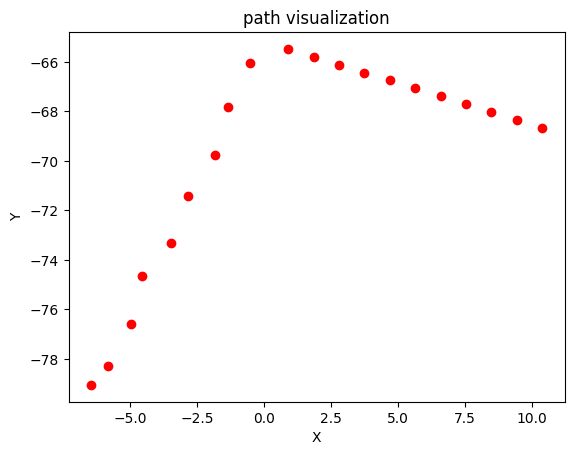

The X coordinates: [-6.446169853210449, -5.8169057240409465, -4.944489133756344, -4.535943176416441, -3.468066327703554, -2.829528211315829, -1.8164704506769511, -1.3234778401188632, -0.5253927471090014, 0.9039747189104231, 1.8518458852872852, 2.7997170516641474, 3.7475882180410096, 4.695459384417871, 5.643330550794734, 6.591201717171597, 7.539072883548459, 8.486944049925322, 9.434815216302185, 10.382686382679049]
The Y coordinates: [-79.05502319335938, -78.27783167530185, -76.58408136544674, -74.65438482682003, -73.33335849102482, -71.43817932421817, -69.7479625157574, -67.82101774527078, -66.03256614741123, -65.47477183584938, -65.79342564792664, -66.1120794600039, -66.43073327208116, -66.74938708415841, -67.06804089623567, -67.38669470831293, -67.70534852039019, -68.02400233246745, -68.3426561445447, -68.66130995662195]
Transform(Location(x=-6.446170, y=-79.055023, z=-0.011602), Rotation(pitch=0.000000, yaw=92.004189, roll=0.000000))
##################
Location(x=-6.446170, y=-79.05

In [115]:
if __name__ == "__main__":
    main()

In [107]:
vehicle.destroy()
lidar_sensor.destroy()

False